# Thermal-RGB 資料對齊診斷與修復工具
## 用於檢查並修復 00_data_diagnosis_and_synchronization.ipynb 的對齊問題

In [1]:
import json
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. 設定路徑

In [2]:
# ==================== 請修改這些路徑 ====================
DATA_DIR = Path('./data')
THERMAL_DIR = DATA_DIR / 'thermal'
CAMERA_DIR = DATA_DIR / 'camera'

AVI_FILE = CAMERA_DIR / 'output.avi'
LABELS_FILE = CAMERA_DIR / 'output.txt'

# 已同步的資料目錄（如果已經執行過原版 notebook）
SYNCHRONIZED_DIR = Path('./output/synchronized')
DIAGNOSIS_OUTPUT = Path('./output/diagnosis_fixed')
DIAGNOSIS_OUTPUT.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Thermal directory: {THERMAL_DIR}")
print(f"AVI file: {AVI_FILE}")
print(f"Labels file: {LABELS_FILE}")
print(f"Synchronized directory: {SYNCHRONIZED_DIR}")
print(f"Diagnosis output: {DIAGNOSIS_OUTPUT}")

Data directory: data
Thermal directory: data/thermal
AVI file: data/camera/output.avi
Labels file: data/camera/output.txt
Synchronized directory: output/synchronized
Diagnosis output: output/diagnosis_fixed


## 2. 診斷 Checklist - 檢查所有資料源

In [3]:
print("="*70)
print("資料對齊診斷 Checklist")
print("="*70)

checklist_results = {}

# 1. 檢查 output.txt
print("\n1. 檢查 output.txt (時間標籤檔):")
if LABELS_FILE.exists():
    with open(LABELS_FILE, 'r', encoding='utf-8') as f:
        labels_content = f.read()
    print(f"   ✓ 檔案存在")
    print(f"   檔案大小: {len(labels_content)} bytes")
    print(f"   行數: {len(labels_content.splitlines())}")
    print(f"\n   前 300 字元:")
    print(f"   {'-'*60}")
    print(f"   {labels_content[:300]}")
    print(f"   {'-'*60}")
    checklist_results['labels_file'] = True
else:
    print("   ❌ 檔案不存在!")
    checklist_results['labels_file'] = False

# 2. 檢查 Thermal log
print("\n2. 檢查 Thermal log 檔案:")
if THERMAL_DIR.exists():
    log_files = sorted(THERMAL_DIR.glob('log*.txt'))
    print(f"   ✓ 目錄存在")
    print(f"   找到 {len(log_files)} 個 log 檔案")
    
    if log_files:
        first_log = log_files[0]
        print(f"\n   第一個檔案: {first_log.name}")
        
        with open(first_log, 'r', encoding='utf-8') as f:
            first_line = f.readline().strip()
            total_lines = sum(1 for _ in f) + 1
        
        print(f"   該檔案行數: {total_lines}")
        print(f"\n   第一行 JSON 範例:")
        print(f"   {'-'*60}")
        print(f"   {first_line[:300]}...")
        print(f"   {'-'*60}")
        
        # 嘗試解析第一行
        try:
            data = json.loads(first_line)
            print(f"\n   ✓ JSON 格式正確")
            print(f"   Keys: {list(data.keys())}")
            if 'time' in data:
                print(f"   Time 欄位: {data['time']}")
            if 'message' in data:
                print(f"   Message 長度: {len(data['message'])} (預期: 768 for 32x24)")
        except Exception as e:
            print(f"   ❌ JSON 解析失敗: {e}")
        
        checklist_results['thermal_logs'] = True
    else:
        print("   ❌ 未找到 log*.txt 檔案")
        checklist_results['thermal_logs'] = False
else:
    print("   ❌ 目錄不存在!")
    checklist_results['thermal_logs'] = False

# 3. 檢查 AVI
print("\n3. 檢查 AVI 影片:")
if AVI_FILE.exists():
    print(f"   ✓ 檔案存在")
    print(f"   檔案大小: {AVI_FILE.stat().st_size / 1024 / 1024:.2f} MB")
    
    cap = cv2.VideoCapture(str(AVI_FILE))
    if cap.isOpened():
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frames / fps if fps > 0 else 0
        
        print(f"   ✓ 可以開啟影片")
        print(f"   解析度: {width} x {height}")
        print(f"   FPS: {fps}")
        print(f"   總幀數: {frames}")
        print(f"   時長: {duration:.2f} 秒")
        
        cap.release()
        checklist_results['avi_file'] = True
        checklist_results['avi_fps'] = fps
        checklist_results['avi_duration'] = duration
    else:
        print("   ❌ 無法開啟影片檔案")
        checklist_results['avi_file'] = False
else:
    print("   ❌ 檔案不存在!")
    checklist_results['avi_file'] = False

# 4. 檢查已配對資料（如果存在）
print("\n4. 檢查已同步的配對資料:")
metadata_file = SYNCHRONIZED_DIR / 'metadata.csv'
if metadata_file.exists():
    meta_df = pd.read_csv(metadata_file)
    print(f"   ✓ metadata.csv 存在")
    print(f"   配對數量: {len(meta_df)}")
    print(f"   欄位: {list(meta_df.columns)}")
    
    if 'thermal_error_ms' in meta_df.columns:
        print(f"\n   Thermal 同步誤差:")
        print(f"     平均: {meta_df['thermal_error_ms'].mean():.2f} ms")
        print(f"     中位數: {meta_df['thermal_error_ms'].median():.2f} ms")
        print(f"     最大: {meta_df['thermal_error_ms'].max():.2f} ms")
        print(f"     標準差: {meta_df['thermal_error_ms'].std():.2f} ms")
    
    if 'rgb_error_ms' in meta_df.columns:
        print(f"\n   RGB 同步誤差:")
        print(f"     平均: {meta_df['rgb_error_ms'].mean():.2f} ms")
        print(f"     中位數: {meta_df['rgb_error_ms'].median():.2f} ms")
        print(f"     最大: {meta_df['rgb_error_ms'].max():.2f} ms")
        print(f"     標準差: {meta_df['rgb_error_ms'].std():.2f} ms")
    
    # 檢查異常高誤差
    if 'thermal_error_ms' in meta_df.columns:
        high_thermal_error = meta_df[meta_df['thermal_error_ms'] > 100]
        if len(high_thermal_error) > 0:
            print(f"\n   ⚠️ 警告: {len(high_thermal_error)} 個配對的 Thermal 誤差 > 100ms")
            print(f"      佔比: {len(high_thermal_error)/len(meta_df)*100:.1f}%")
    
    if 'rgb_error_ms' in meta_df.columns:
        high_rgb_error = meta_df[meta_df['rgb_error_ms'] > 100]
        if len(high_rgb_error) > 0:
            print(f"\n   ⚠️ 警告: {len(high_rgb_error)} 個配對的 RGB 誤差 > 100ms")
            print(f"      佔比: {len(high_rgb_error)/len(meta_df)*100:.1f}%")
    
    checklist_results['synchronized_data'] = True
else:
    print("   ℹ️ metadata.csv 尚未產生（需先執行同步）")
    checklist_results['synchronized_data'] = False

print("\n" + "="*70)
print("診斷完成")
print("="*70)

資料對齊診斷 Checklist

1. 檢查 output.txt (時間標籤檔):
   ✓ 檔案存在
   檔案大小: 899 bytes
   行數: 30

   前 300 字元:
   ------------------------------------------------------------
   viedo_start_2020-09-24 13:09:29 
lay_mid_2020-09-24 13:11:08 
end_time_2020-09-24 13:11:43 
lay_right_2020-09-24 13:12:02 
end_time_2020-09-24 13:12:39 
lay_left_2020-09-24 13:12:58 
end_time_2020-09-24 13:13:36 
bed_2020-09-24 13:13:53 
end_time_2020-09-24 13:14:32 
sit_right_2020-09-24 13:14:40 
e
   ------------------------------------------------------------

2. 檢查 Thermal log 檔案:
   ✓ 目錄存在
   找到 5 個 log 檔案

   第一個檔案: log000.txt
   該檔案行數: 1283

   第一行 JSON 範例:
   ------------------------------------------------------------
   {"time": [2020, 9, 24, 13, 9, 30, 3, 268, 0], "message": [120, 122, 121, 126, 131, 109, 128, 129, 128, 124, 125, 140, 139, 134, 129, 137, 138, 143, 134, 146, 134, 130, 128, 136, 136, 127, 134, 135, 141, 130, 127, 122, 116, 127, 125, 121, 125, 127, 125, 126, 127, 132, 128, 132, 126, 130, 137, 132, 13

## 3. 視覺化檢查已配對的資料

視覺化檢查配對結果...

檢查 8 個配對樣本...

配對 #0 (pair_00000):
  時間戳: 2020-09-24 13:09:30.268
  RGB 幀索引: 0
  Thermal 誤差: 0.00ms
  RGB 誤差: 0.00ms

配對 #94 (pair_00094):
  時間戳: 2020-09-24 13:11:04.268
  RGB 幀索引: 2318
  Thermal 誤差: 0.00ms
  RGB 誤差: 39.72ms

配對 #188 (pair_00188):
  時間戳: 2020-09-24 13:12:38.268
  RGB 幀索引: 4637
  Thermal 誤差: 0.00ms
  RGB 誤差: 38.91ms

配對 #282 (pair_00282):
  時間戳: 2020-09-24 13:14:12.268
  RGB 幀索引: 6956
  Thermal 誤差: 0.00ms
  RGB 誤差: 38.10ms

配對 #377 (pair_00377):
  時間戳: 2020-09-24 13:15:47.268
  RGB 幀索引: 9300
  Thermal 誤差: 0.00ms
  RGB 誤差: 23.92ms

配對 #471 (pair_00471):
  時間戳: 2020-09-24 13:17:21.268
  RGB 幀索引: 11619
  Thermal 誤差: 0.00ms
  RGB 誤差: 23.10ms

配對 #565 (pair_00565):
  時間戳: 2020-09-24 13:18:55.268
  RGB 幀索引: 13938
  Thermal 誤差: 0.00ms
  RGB 誤差: 22.29ms

配對 #660 (pair_00660):
  時間戳: 2020-09-24 13:20:30.268
  RGB 幀索引: 16282
  Thermal 誤差: 0.00ms
  RGB 誤差: 8.11ms



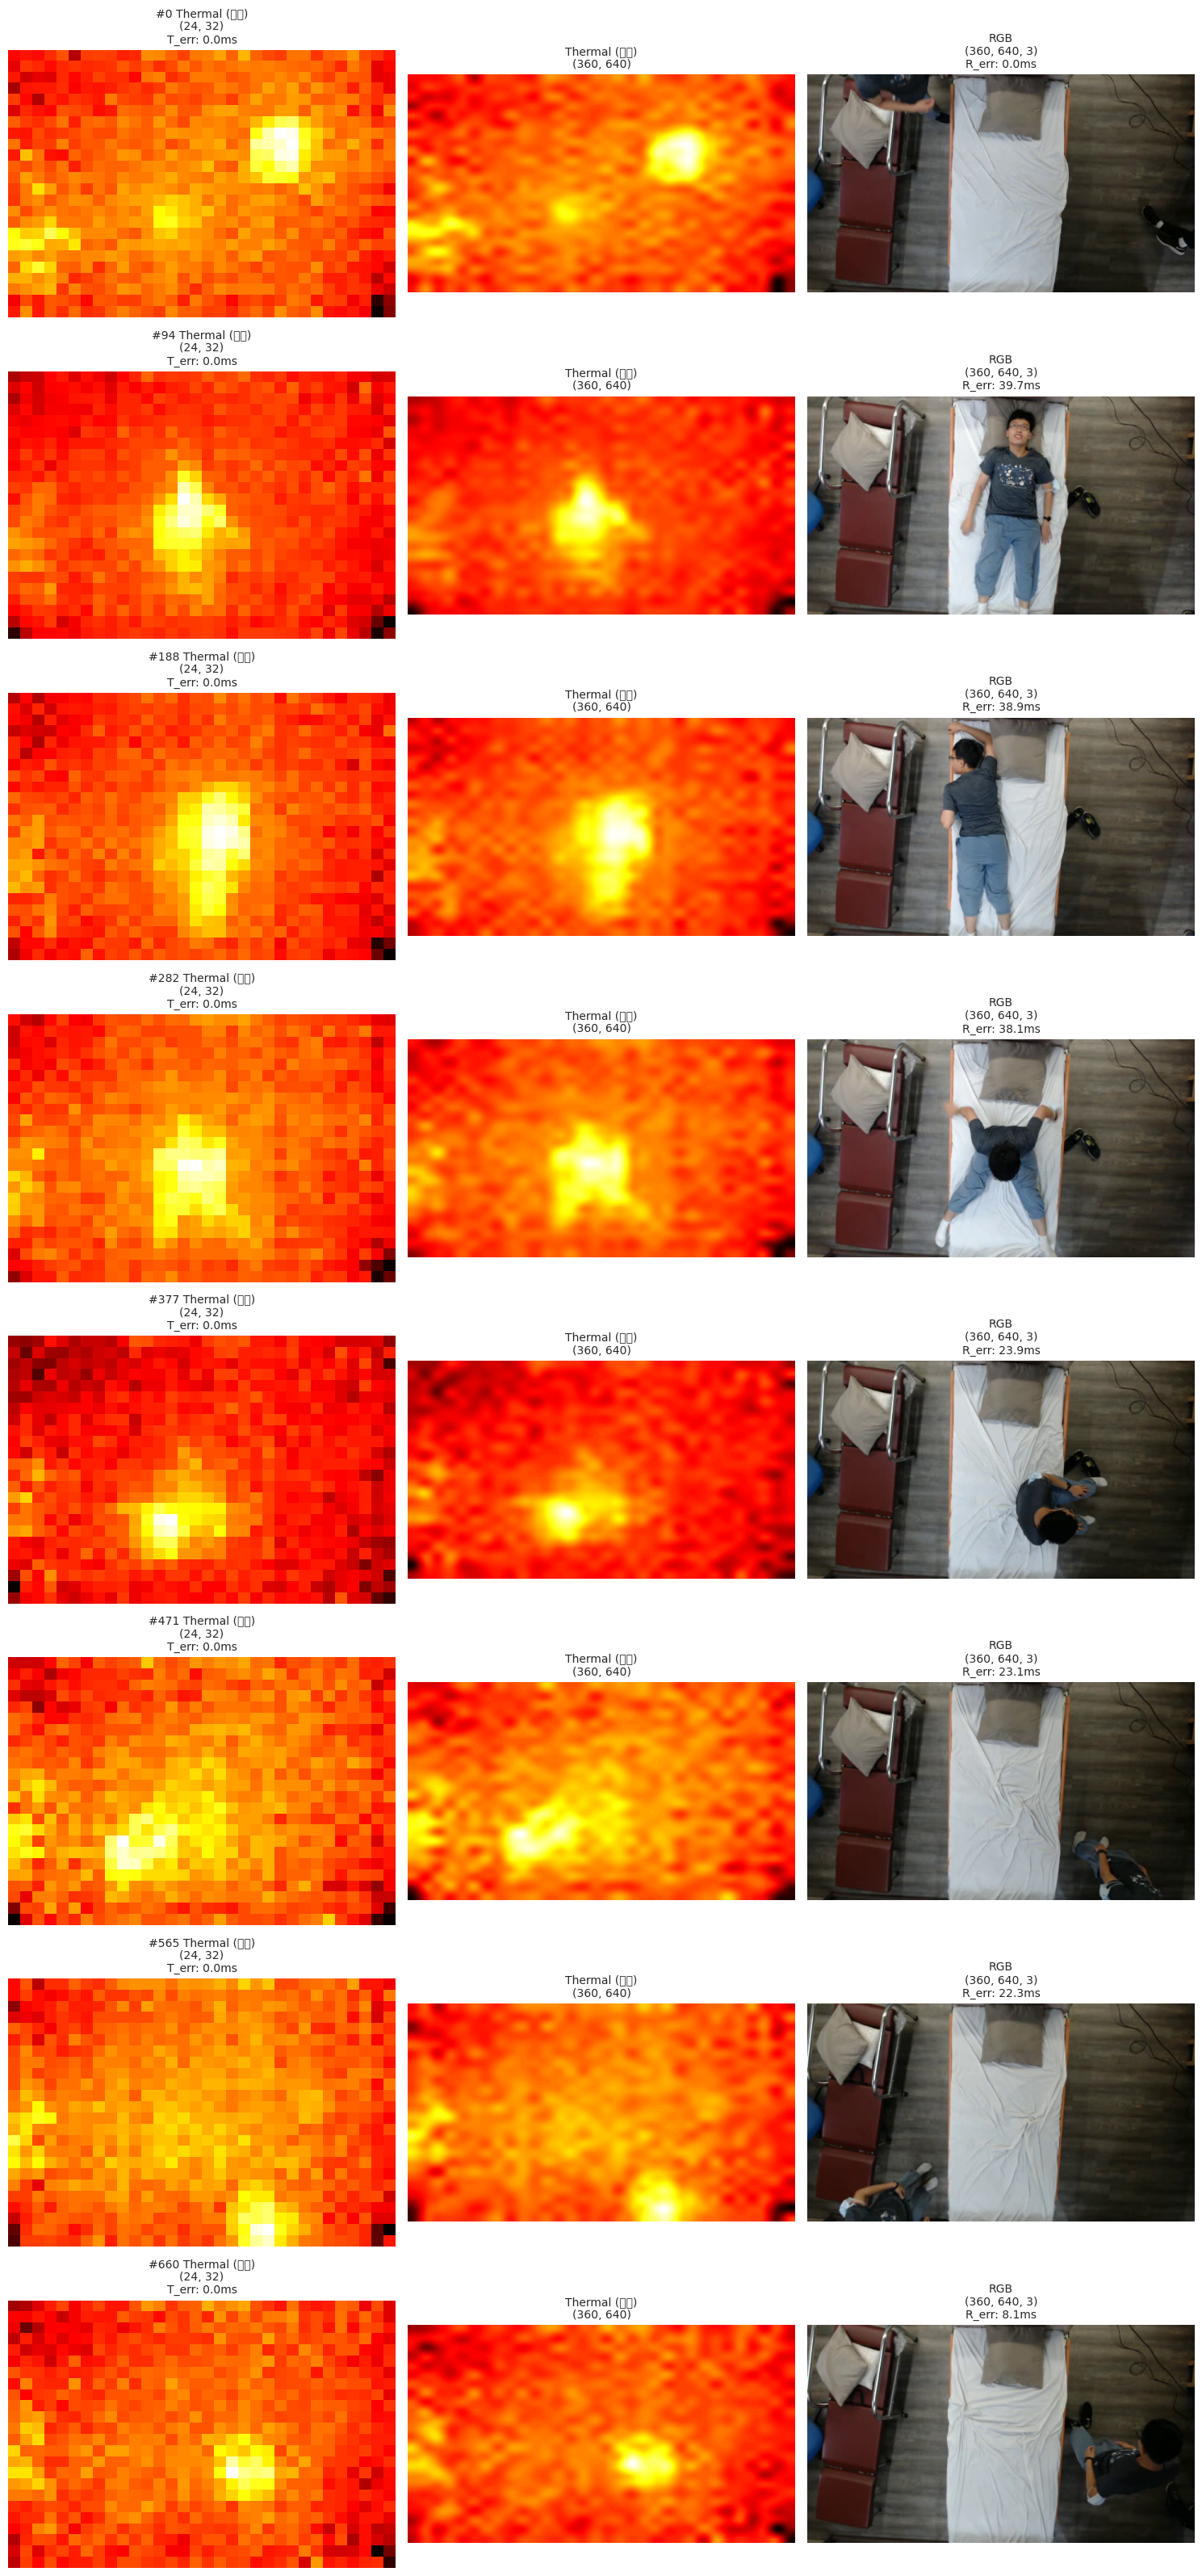


✓ 視覺化已儲存至: output/diagnosis_fixed/paired_samples_check.png

請檢查上圖，看 Thermal 和 RGB 是否對應到相同的場景/時間點
如果畫面明顯不同步，表示時間對齊有問題！


In [4]:
if checklist_results.get('synchronized_data', False):
    print("視覺化檢查配對結果...\n")
    
    # 載入 metadata
    meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')
    
    # 選擇要檢查的樣本（均勻分佈）
    num_samples = min(8, len(meta_df))
    sample_indices = np.linspace(0, len(meta_df) - 1, num_samples, dtype=int)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    print(f"檢查 {num_samples} 個配對樣本...\n")
    
    for plot_idx, data_idx in enumerate(sample_indices):
        row = meta_df.iloc[data_idx]
        pair_id = row['pair_id']
        
        # 載入 thermal
        thermal_path = SYNCHRONIZED_DIR / 'thermal' / f"{pair_id}_thermal.npy"
        if thermal_path.exists():
            thermal = np.load(thermal_path)
        else:
            print(f"⚠️ Thermal 檔案不存在: {thermal_path}")
            continue
        
        # 載入 RGB
        rgb_path = SYNCHRONIZED_DIR / 'rgb' / f"{pair_id}_rgb.npy"
        if rgb_path.exists():
            rgb = np.load(rgb_path)
        else:
            print(f"⚠️ RGB 檔案不存在: {rgb_path}")
            continue
        
        # 顯示原始 Thermal (32x24)
        axes[plot_idx, 0].imshow(thermal, cmap='hot', aspect='auto')
        axes[plot_idx, 0].set_title(
            f'#{data_idx} Thermal (原始)\n{thermal.shape}\n'
            f'T_err: {row["thermal_error_ms"]:.1f}ms',
            fontsize=10
        )
        axes[plot_idx, 0].axis('off')
        
        # 顯示放大後的 Thermal (配合 RGB 尺寸)
        thermal_upscaled = cv2.resize(
            thermal, 
            (rgb.shape[1], rgb.shape[0]), 
            interpolation=cv2.INTER_CUBIC
        )
        axes[plot_idx, 1].imshow(thermal_upscaled, cmap='hot')
        axes[plot_idx, 1].set_title(
            f'Thermal (放大)\n{thermal_upscaled.shape}',
            fontsize=10
        )
        axes[plot_idx, 1].axis('off')
        
        # 顯示 RGB
        axes[plot_idx, 2].imshow(rgb)
        axes[plot_idx, 2].set_title(
            f'RGB\n{rgb.shape}\n'
            f'R_err: {row["rgb_error_ms"]:.1f}ms',
            fontsize=10
        )
        axes[plot_idx, 2].axis('off')
        
        # 在 console 顯示詳細資訊
        print(f"配對 #{data_idx} ({pair_id}):")
        if 'timestamp' in row:
            print(f"  時間戳: {row['timestamp']}")
        if 'rgb_frame_idx' in row:
            print(f"  RGB 幀索引: {row['rgb_frame_idx']}")
        print(f"  Thermal 誤差: {row['thermal_error_ms']:.2f}ms")
        print(f"  RGB 誤差: {row['rgb_error_ms']:.2f}ms")
        print()
    
    plt.tight_layout()
    output_path = DIAGNOSIS_OUTPUT / 'paired_samples_check.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ 視覺化已儲存至: {output_path}")
    print("\n請檢查上圖，看 Thermal 和 RGB 是否對應到相同的場景/時間點")
    print("如果畫面明顯不同步，表示時間對齊有問題！")
else:
    print("⚠️ 尚未產生配對資料，請先執行原版 notebook 進行同步")

## 4. 分析同步誤差分佈

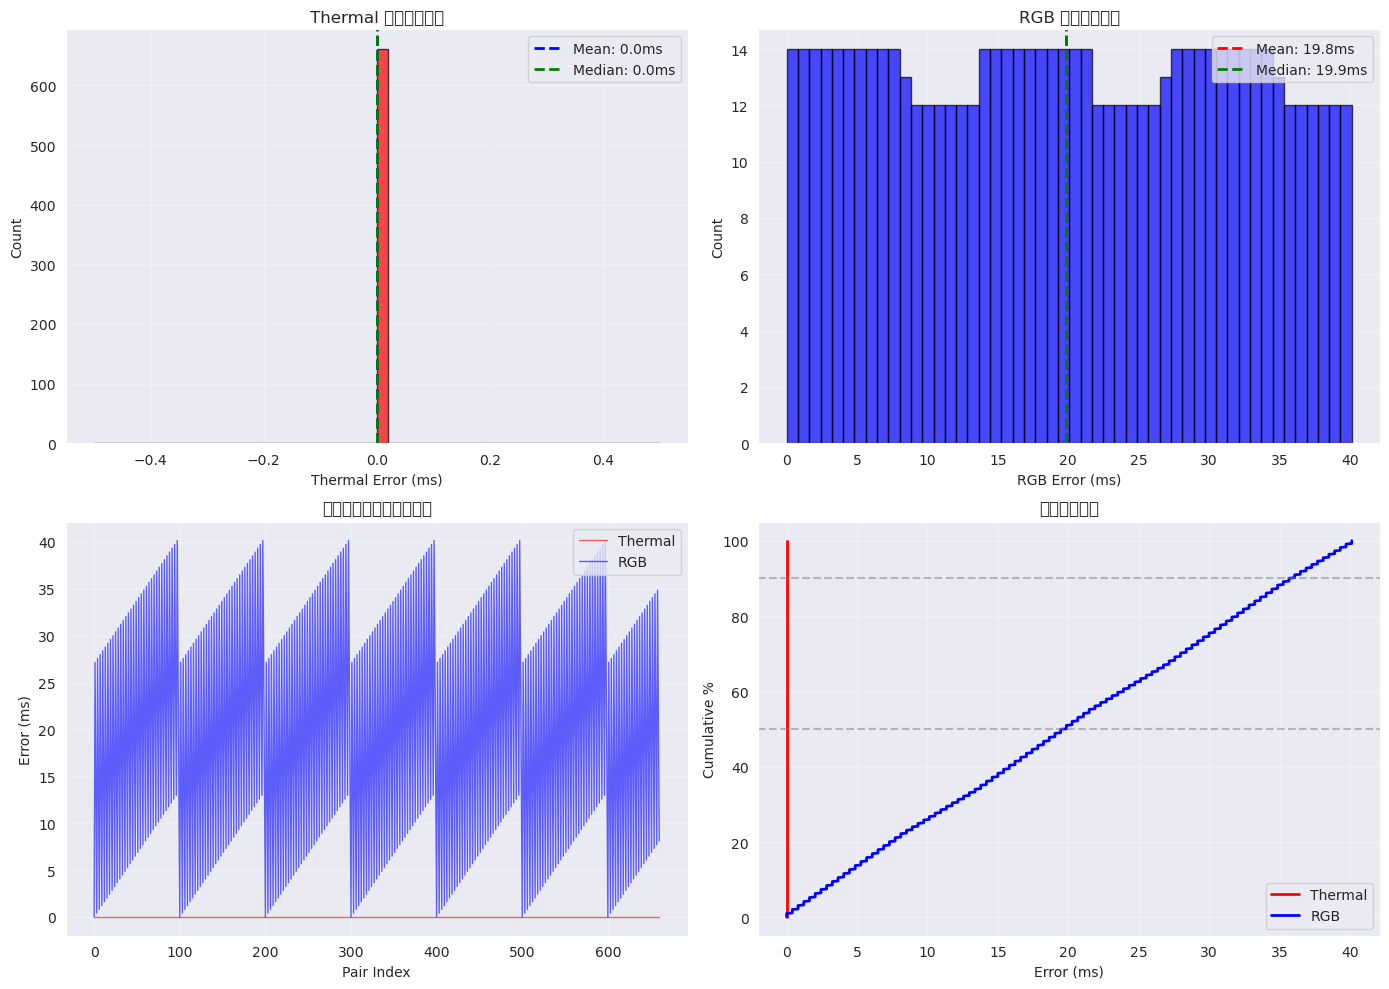


✓ 誤差分析圖已儲存至: output/diagnosis_fixed/synchronization_errors.png

同步品質評估

Thermal 同步品質:
  50% 配對誤差 < 0.00ms
  90% 配對誤差 < 0.00ms

RGB 同步品質:
  50% 配對誤差 < 19.86ms
  90% 配對誤差 < 35.67ms

整體品質評級:
  ✓ 優秀 (平均誤差 9.9ms < 50ms)



In [5]:
if checklist_results.get('synchronized_data', False):
    meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Thermal 誤差分佈
    if 'thermal_error_ms' in meta_df.columns:
        axes[0, 0].hist(meta_df['thermal_error_ms'], bins=50, edgecolor='black', alpha=0.7, color='red')
        axes[0, 0].axvline(meta_df['thermal_error_ms'].mean(), color='blue', 
                          linestyle='--', linewidth=2, label=f'Mean: {meta_df["thermal_error_ms"].mean():.1f}ms')
        axes[0, 0].axvline(meta_df['thermal_error_ms'].median(), color='green', 
                          linestyle='--', linewidth=2, label=f'Median: {meta_df["thermal_error_ms"].median():.1f}ms')
        axes[0, 0].set_xlabel('Thermal Error (ms)')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title('Thermal 同步誤差分佈')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: RGB 誤差分佈
    if 'rgb_error_ms' in meta_df.columns:
        axes[0, 1].hist(meta_df['rgb_error_ms'], bins=50, edgecolor='black', alpha=0.7, color='blue')
        axes[0, 1].axvline(meta_df['rgb_error_ms'].mean(), color='red', 
                          linestyle='--', linewidth=2, label=f'Mean: {meta_df["rgb_error_ms"].mean():.1f}ms')
        axes[0, 1].axvline(meta_df['rgb_error_ms'].median(), color='green', 
                          linestyle='--', linewidth=2, label=f'Median: {meta_df["rgb_error_ms"].median():.1f}ms')
        axes[0, 1].set_xlabel('RGB Error (ms)')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('RGB 同步誤差分佈')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: 誤差隨時間變化
    axes[1, 0].plot(meta_df.index, meta_df['thermal_error_ms'], 
                   alpha=0.6, linewidth=1, label='Thermal', color='red')
    axes[1, 0].plot(meta_df.index, meta_df['rgb_error_ms'], 
                   alpha=0.6, linewidth=1, label='RGB', color='blue')
    axes[1, 0].set_xlabel('Pair Index')
    axes[1, 0].set_ylabel('Error (ms)')
    axes[1, 0].set_title('同步誤差隨配對順序變化')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Cumulative error distribution
    thermal_sorted = np.sort(meta_df['thermal_error_ms'].values)
    rgb_sorted = np.sort(meta_df['rgb_error_ms'].values)
    
    thermal_cum = np.arange(1, len(thermal_sorted) + 1) / len(thermal_sorted) * 100
    rgb_cum = np.arange(1, len(rgb_sorted) + 1) / len(rgb_sorted) * 100
    
    axes[1, 1].plot(thermal_sorted, thermal_cum, linewidth=2, label='Thermal', color='red')
    axes[1, 1].plot(rgb_sorted, rgb_cum, linewidth=2, label='RGB', color='blue')
    axes[1, 1].axhline(50, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(90, color='gray', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Error (ms)')
    axes[1, 1].set_ylabel('Cumulative %')
    axes[1, 1].set_title('累積誤差分佈')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    error_plot_path = DIAGNOSIS_OUTPUT / 'synchronization_errors.png'
    plt.savefig(error_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ 誤差分析圖已儲存至: {error_plot_path}")
    
    # 統計報告
    print("\n" + "="*70)
    print("同步品質評估")
    print("="*70)
    
    thermal_50 = np.percentile(meta_df['thermal_error_ms'], 50)
    thermal_90 = np.percentile(meta_df['thermal_error_ms'], 90)
    rgb_50 = np.percentile(meta_df['rgb_error_ms'], 50)
    rgb_90 = np.percentile(meta_df['rgb_error_ms'], 90)
    
    print(f"\nThermal 同步品質:")
    print(f"  50% 配對誤差 < {thermal_50:.2f}ms")
    print(f"  90% 配對誤差 < {thermal_90:.2f}ms")
    
    print(f"\nRGB 同步品質:")
    print(f"  50% 配對誤差 < {rgb_50:.2f}ms")
    print(f"  90% 配對誤差 < {rgb_90:.2f}ms")
    
    # 品質評級
    avg_error = (meta_df['thermal_error_ms'].mean() + meta_df['rgb_error_ms'].mean()) / 2
    
    print(f"\n整體品質評級:")
    if avg_error < 50:
        print(f"  ✓ 優秀 (平均誤差 {avg_error:.1f}ms < 50ms)")
    elif avg_error < 100:
        print(f"  ⚠️ 良好 (平均誤差 {avg_error:.1f}ms < 100ms)")
    else:
        print(f"  ❌ 需改進 (平均誤差 {avg_error:.1f}ms >= 100ms)")
        print(f"     建議檢查時間對齊設定！")
    
    print("\n" + "="*70)
else:
    print("⚠️ 尚未產生配對資料")

## 5. 產生診斷報告

In [6]:
# 產生文字報告
report_lines = []
report_lines.append("="*70)
report_lines.append("Thermal-RGB 資料對齊診斷報告")
report_lines.append(f"產生時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append("="*70)

report_lines.append("\n1. 資料源檢查")
report_lines.append("-" * 70)
report_lines.append(f"output.txt: {'✓ 存在' if checklist_results.get('labels_file') else '❌ 不存在'}")
report_lines.append(f"Thermal logs: {'✓ 存在' if checklist_results.get('thermal_logs') else '❌ 不存在'}")
report_lines.append(f"AVI 影片: {'✓ 存在' if checklist_results.get('avi_file') else '❌ 不存在'}")

if checklist_results.get('avi_file'):
    report_lines.append(f"  - FPS: {checklist_results.get('avi_fps', 'N/A')}")
    report_lines.append(f"  - 時長: {checklist_results.get('avi_duration', 0):.2f}s")

if checklist_results.get('synchronized_data'):
    meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')
    
    report_lines.append("\n2. 同步資料統計")
    report_lines.append("-" * 70)
    report_lines.append(f"配對總數: {len(meta_df)}")
    
    if 'thermal_error_ms' in meta_df.columns:
        report_lines.append(f"\nThermal 同步誤差:")
        report_lines.append(f"  平均: {meta_df['thermal_error_ms'].mean():.2f}ms")
        report_lines.append(f"  中位數: {meta_df['thermal_error_ms'].median():.2f}ms")
        report_lines.append(f"  最大: {meta_df['thermal_error_ms'].max():.2f}ms")
        report_lines.append(f"  標準差: {meta_df['thermal_error_ms'].std():.2f}ms")
    
    if 'rgb_error_ms' in meta_df.columns:
        report_lines.append(f"\nRGB 同步誤差:")
        report_lines.append(f"  平均: {meta_df['rgb_error_ms'].mean():.2f}ms")
        report_lines.append(f"  中位數: {meta_df['rgb_error_ms'].median():.2f}ms")
        report_lines.append(f"  最大: {meta_df['rgb_error_ms'].max():.2f}ms")
        report_lines.append(f"  標準差: {meta_df['rgb_error_ms'].std():.2f}ms")
    
    # 品質評估
    avg_error = (meta_df['thermal_error_ms'].mean() + meta_df['rgb_error_ms'].mean()) / 2
    
    report_lines.append("\n3. 品質評估")
    report_lines.append("-" * 70)
    report_lines.append(f"整體平均誤差: {avg_error:.2f}ms")
    
    if avg_error < 50:
        report_lines.append("品質: ✓ 優秀")
    elif avg_error < 100:
        report_lines.append("品質: ⚠️ 良好")
    else:
        report_lines.append("品質: ❌ 需改進")
        report_lines.append("建議: 檢查 output.txt 時間設定或調整容忍度參數")
    
    # 異常檢測
    high_thermal = meta_df[meta_df['thermal_error_ms'] > 100]
    high_rgb = meta_df[meta_df['rgb_error_ms'] > 100]
    
    if len(high_thermal) > 0 or len(high_rgb) > 0:
        report_lines.append("\n4. 異常警告")
        report_lines.append("-" * 70)
        if len(high_thermal) > 0:
            report_lines.append(f"⚠️ {len(high_thermal)} 個配對的 Thermal 誤差 > 100ms")
        if len(high_rgb) > 0:
            report_lines.append(f"⚠️ {len(high_rgb)} 個配對的 RGB 誤差 > 100ms")

report_lines.append("\n" + "="*70)
report_lines.append("診斷完成")
report_lines.append("="*70)

# 顯示報告
report_text = "\n".join(report_lines)
print(report_text)

# 儲存報告
report_path = DIAGNOSIS_OUTPUT / 'diagnosis_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)

print(f"\n✓ 報告已儲存至: {report_path}")

Thermal-RGB 資料對齊診斷報告
產生時間: 2025-11-03 13:01:47

1. 資料源檢查
----------------------------------------------------------------------
output.txt: ✓ 存在
Thermal logs: ✓ 存在
AVI 影片: ✓ 存在
  - FPS: 24.67
  - 時長: 660.07s

2. 同步資料統計
----------------------------------------------------------------------
配對總數: 661

Thermal 同步誤差:
  平均: 0.00ms
  中位數: 0.00ms
  最大: 0.00ms
  標準差: 0.00ms

RGB 同步誤差:
  平均: 19.81ms
  中位數: 19.86ms
  最大: 40.13ms
  標準差: 11.70ms

3. 品質評估
----------------------------------------------------------------------
整體平均誤差: 9.91ms
品質: ✓ 優秀

診斷完成

✓ 報告已儲存至: output/diagnosis_fixed/diagnosis_report.txt


## 6. 問題分析與建議

In [7]:
print("\n" + "="*70)
print("問題分析與修復建議")
print("="*70)

if checklist_results.get('synchronized_data'):
    meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')
    avg_error = (meta_df['thermal_error_ms'].mean() + meta_df['rgb_error_ms'].mean()) / 2
    
    print("\n根據診斷結果，以下是可能的問題和建議:\n")
    
    if avg_error > 100:
        print("❌ 主要問題: 同步誤差過大 (>100ms)")
        print("\n可能原因:")
        print("  1. output.txt 的起始時間不正確")
        print("     → 請檢查 output.txt 內容")
        print("     → 手動確認影片和 thermal 的實際開始時間")
        print()
        print("  2. Thermal log 的時間戳解析錯誤")
        print("     → 檢查 JSON 的 'time' 欄位格式")
        print("     → 確認 millisecond 位置 (index 6 或 7)")
        print()
        print("  3. AVI 影片的 FPS 不準確")
        print(f"     → 當前偵測 FPS: {checklist_results.get('avi_fps', 'N/A')}")
        print("     → 可能需要手動指定正確的 FPS")
    
    elif avg_error > 50:
        print("⚠️ 次要問題: 同步誤差偏高 (50-100ms)")
        print("\n建議:")
        print("  - 可以嘗試調整 TIMESTAMP_TOLERANCE 參數")
        print("  - 檢查是否有 Thermal dropout 影響對齊")
    
    else:
        print("✓ 同步品質良好 (<50ms)")
        print("\n如果視覺檢查仍有問題，可能是:")
        print("  - Thermal 和 RGB 的場景內容本來就不同")
        print("  - 相機視角或位置不同")
    
    print("\n" + "-"*70)
    print("下一步:")
    print("-"*70)
    print("\n1. 查看以下生成的圖表:")
    print(f"   - {DIAGNOSIS_OUTPUT / 'paired_samples_check.png'}")
    print(f"   - {DIAGNOSIS_OUTPUT / 'synchronization_errors.png'}")
    print()
    print("2. 如果發現問題，請回報:")
    print("   a. output.txt 的內容 (前幾行)")
    print("   b. Thermal log 第一行的 JSON 範例")
    print("   c. 錯誤配對的樣本圖片")
    print("   d. metadata.csv 的前幾行")
    print()
    print("3. 我會根據您提供的資訊修復對齊程式")
    
else:
    print("\nℹ️ 尚未執行同步，請先:")
    print("  1. 執行原版 00_data_diagnosis_and_synchronization.ipynb")
    print("  2. 然後重新執行本診斷 notebook")

print("\n" + "="*70)


問題分析與修復建議

根據診斷結果，以下是可能的問題和建議:

✓ 同步品質良好 (<50ms)

如果視覺檢查仍有問題，可能是:
  - Thermal 和 RGB 的場景內容本來就不同
  - 相機視角或位置不同

----------------------------------------------------------------------
下一步:
----------------------------------------------------------------------

1. 查看以下生成的圖表:
   - output/diagnosis_fixed/paired_samples_check.png
   - output/diagnosis_fixed/synchronization_errors.png

2. 如果發現問題，請回報:
   a. output.txt 的內容 (前幾行)
   b. Thermal log 第一行的 JSON 範例
   c. 錯誤配對的樣本圖片
   d. metadata.csv 的前幾行

3. 我會根據您提供的資訊修復對齊程式



In [8]:
# 深入診斷：找出錯誤配對的模式
import numpy as np
import pandas as pd
from pathlib import Path

SYNCHRONIZED_DIR = Path('./output/synchronized')
meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')

print("="*70)
print("錯誤配對診斷分析")
print("="*70)

# 1. 顯示所有配對的詳細資訊
print(f"\n總配對數: {len(meta_df)}")
print(f"\n前 20 個配對的詳細資訊:")
print("-"*70)

for i in range(min(20, len(meta_df))):
    row = meta_df.iloc[i]
    print(f"\n配對 #{i}:")
    print(f"  Pair ID: {row['pair_id']}")
    print(f"  Timestamp: {row['timestamp']}")
    print(f"  RGB Frame Index: {row['rgb_frame_idx']}")
    print(f"  Thermal Error: {row['thermal_error_ms']:.2f}ms")
    print(f"  RGB Error: {row['rgb_error_ms']:.2f}ms")
    print(f"  Thermal File: {row['thermal_file']}")

# 2. 分析 RGB 幀索引的跳躍
print("\n" + "="*70)
print("RGB 幀索引分析")
print("="*70)

rgb_indices = meta_df['rgb_frame_idx'].values
rgb_diffs = np.diff(rgb_indices)

print(f"\nRGB 幀索引範圍: {rgb_indices.min()} ~ {rgb_indices.max()}")
print(f"平均幀索引差: {rgb_diffs.mean():.2f}")
print(f"最大幀索引差: {rgb_diffs.max()}")
print(f"最小幀索引差: {rgb_diffs.min()}")

# 找出異常大的跳躍
large_jumps = np.where(rgb_diffs > rgb_diffs.mean() + 2*rgb_diffs.std())[0]
if len(large_jumps) > 0:
    print(f"\n⚠️ 發現 {len(large_jumps)} 個異常大的幀跳躍:")
    for jump_idx in large_jumps[:10]:
        print(f"  配對 #{jump_idx} -> #{jump_idx+1}: 幀 {rgb_indices[jump_idx]} -> {rgb_indices[jump_idx+1]} (跳了 {rgb_diffs[jump_idx]} 幀)")

# 找出異常小的跳躍（可能重複）
small_jumps = np.where(rgb_diffs < 1)[0]
if len(small_jumps) > 0:
    print(f"\n⚠️ 發現 {len(small_jumps)} 個重複或倒退的幀:")
    for jump_idx in small_jumps[:10]:
        print(f"  配對 #{jump_idx} -> #{jump_idx+1}: 幀 {rgb_indices[jump_idx]} -> {rgb_indices[jump_idx+1]} (差 {rgb_diffs[jump_idx]})")

# 3. 分析時間戳
print("\n" + "="*70)
print("時間戳分析")
print("="*70)

timestamps = pd.to_datetime(meta_df['timestamp'])
time_diffs = timestamps.diff().dt.total_seconds()

print(f"\n時間戳範圍: {timestamps.min()} ~ {timestamps.max()}")
print(f"總時長: {(timestamps.max() - timestamps.min()).total_seconds():.2f} 秒")
print(f"平均時間間隔: {time_diffs.mean():.4f} 秒")
print(f"理想間隔 (8fps): 0.125 秒")

# 找出時間戳異常
time_jumps = np.where(time_diffs > 0.25)[0]  # >2倍預期間隔
if len(time_jumps) > 0:
    print(f"\n⚠️ 發現 {len(time_jumps)} 個時間戳大跳躍:")
    for idx in time_jumps[:10]:
        print(f"  配對 #{idx-1} -> #{idx}: {time_diffs.iloc[idx]:.3f} 秒")

# 4. 檢查錯誤配對的位置模式
print("\n" + "="*70)
print("請手動標記錯誤的配對")
print("="*70)
print("\n根據您說的「4張對、2張錯」，請告訴我:")
print("在視覺化圖中（8個樣本），哪些編號是錯的？")
print("例如: #2 和 #5 是錯的")

錯誤配對診斷分析

總配對數: 661

前 20 個配對的詳細資訊:
----------------------------------------------------------------------

配對 #0:
  Pair ID: pair_00000
  Timestamp: 2020-09-24 13:09:30.268
  RGB Frame Index: 0
  Thermal Error: 0.00ms
  RGB Error: 0.00ms
  Thermal File: log000.txt

配對 #1:
  Pair ID: pair_00001
  Timestamp: 2020-09-24 13:09:31.268
  RGB Frame Index: 24
  Thermal Error: 0.00ms
  RGB Error: 27.16ms
  Thermal File: log000.txt

配對 #2:
  Pair ID: pair_00002
  Timestamp: 2020-09-24 13:09:32.268
  RGB Frame Index: 49
  Thermal Error: 0.00ms
  RGB Error: 13.78ms
  Thermal File: log000.txt

配對 #3:
  Pair ID: pair_00003
  Timestamp: 2020-09-24 13:09:33.268
  RGB Frame Index: 74
  Thermal Error: 0.00ms
  RGB Error: 0.41ms
  Thermal File: log000.txt

配對 #4:
  Pair ID: pair_00004
  Timestamp: 2020-09-24 13:09:34.268
  RGB Frame Index: 98
  Thermal Error: 0.00ms
  RGB Error: 27.56ms
  Thermal File: log000.txt

配對 #5:
  Pair ID: pair_00005
  Timestamp: 2020-09-24 13:09:35.268
  RGB Frame Index: 123
 